### Download required libraries

In [ ]:
!pip install opendatasets
!pip install tensorboard

### Import libraries

In [ ]:
import torch
from torch.functional import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support)

import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from collections import OrderedDict
plt.ion()

device = ('cuda' if torch.cuda.is_available() else 'cpu')
cuda1 = torch.device(device)
num_workers = 0

### Download dataset

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset'  # Replace with the URL of the dataset you want to download
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: revumythili
Your Kaggle Key: ··········


100%|██████████| 663M/663M [00:07<00:00, 89.3MB/s]


In [ ]:

d_path = "./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
dataset_path = Path(d_path)


n_data_path = dataset_path / "Normal"
t_data_path = dataset_path / "Tuberculosis"

## Functions

In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
matplotlib.style.use('ggplot')

def show_plot(x,y,title='Number of cases',xlabel='Case type',ylabel='Count'
              ,xticks=['Normal(0)' ,"Tuberculosis(1)"]):
    plt.figure(figsize=(10,8))
    sns.barplot(x = x, y = y)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(range(len(x)), xticks)
    plt.show()

def save_model(epochs, model, optimizer, criterion):
    """
    Save the trained model parameters to disk.
    """
    base_dir='./models'
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, base_dir+f'/model_{epochs}.pth')

def load_model(model,path='',opt= optim.Adam):
  """
  Load model state from file
  """
  dic = torch.load(path,device)
  model = model.load_state_dict(dic["model_state_dict"])

  return model , dic['loss'],dic['optimizer_state_dict']


def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Save the Loss and Accuracy plots to disk.
    """

    base_dir="/content"


    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(base_dir+'/outputs/accuracy_.png')


    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(base_dir+'/outputs/loss_.png')

def train(model, trainloader, optimizer, criterion):
    """
    Train model for one epoch on dataloder
    """
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    preds_list=[]
    labels_list=[]
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs.squeeze(), labels.float())
        train_running_loss += loss.item()
        preds = torch.heaviside(outputs.data,torch.tensor([1.0]).to(device)).squeeze()
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    preds_list=[]
    labels_list=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            outputs = model(image)
            loss = criterion(outputs.squeeze(), labels.float())
            valid_running_loss += loss.item()
            preds = torch.heaviside(outputs.data,torch.tensor([1.0]).to(device)).squeeze()

            labels_list += (labels).tolist()
            preds_list += (preds).tolist()
            valid_running_correct += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc ,preds_list, labels_list

def train_val_dataset(dataset, val_split=0.20,random_state=0):
    """
    split dataset into validation and train parts by the proportion of val_split
    """
    data_lables = [it[1] for it in dataset]
    train_idx, val_idx = train_test_split(
        list(range(len(dataset))),random_state=random_state, test_size=val_split,
         stratify=data_lables)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)

    datasets['val'] = Subset(dataset, val_idx)
    return datasets



## Load images

In [ ]:
transform = transforms.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
data=datasets.ImageFolder(root=str(dataset_path),transform=transform)

dataset=train_val_dataset(data,val_split=600)
train_count=np.unique([it[1] for it in dataset['train']],return_counts=True)
print("number of labels in train set is", train_count)
train_loader = DataLoader(
    dataset['train'], batch_size=18, shuffle=True,
    num_workers=num_workers, pin_memory=True
)
test_loader = DataLoader(
    dataset['val'], batch_size=30, shuffle=False,
    num_workers=num_workers, pin_memory=True)



number of labels in train set is (array([0, 1]), array([3000,  600]))


## Define model

In [ ]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(15,15))
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(OrderedDict([
                          ('dropout1', nn.Dropout(p=0.05)),
                          ('fc1', nn.Linear(57600, 510)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(510, 1)),
                          # ('output', nn.Sigmoid())
                          ]))

model=model.to(device)
print(f"Updated model:\n{model}\n")
from torchsummary import summary
summary(model,(3,512,512),batch_size=18)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 133MB/s]


Updated model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(15, 15))
  (classifier): Sequential(
    (dropout1): Dropout(p=0.05, inplace=False)
    (fc1): Linear(in_features=57600, out

### Training loop


In [ ]:
lr=0.0001
num_epochs = 3
cuda1 = torch.device(device)
class_weights = Tensor([5]) # for class 1 weight is 5 times of class 0
class_weights = class_weights.to(cuda1)
optimizer = optim.Adam(model.classifier.parameters(),lr=lr)
criterion = nn.BCEWithLogitsLoss()

class_weights.get_device()


0

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                              optimizer, criterion)
    (valid_epoch_loss, valid_epoch_acc,
     preds_list, labels_list) = validate(model, test_loader, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    prec, rec, f1,_ =precision_recall_fscore_support(labels_list,preds_list)
    print(f"Training loss: {train_epoch_loss:.6f}, training acc: {train_epoch_acc:.6f}")
    print(f"Validation loss: {valid_epoch_loss:.6f}, validation acc: {valid_epoch_acc:.6f},")
    for l in [0,1]:
        print(f"for class[{l}]:\n validation precision: {prec[l]:.5f}, validation recall: {rec[l]:.5f} , validation F1: {f1[l]:.4f}")

    print('-'*50)
    time.sleep(4)



[INFO]: Epoch 1 of 3
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.041504, training acc: 98.750000
Validation loss: 0.037879, validation acc: 99.333333,
for class[0]:
 validation precision: 0.99206, validation recall: 1.00000 , validation F1: 0.9960
for class[1]:
 validation precision: 1.00000, validation recall: 0.96000 , validation F1: 0.9796
--------------------------------------------------
[INFO]: Epoch 2 of 3
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.002143, training acc: 99.972222
Validation loss: 0.014634, validation acc: 99.333333,
for class[0]:
 validation precision: 0.99402, validation recall: 0.99800 , validation F1: 0.9960
for class[1]:
 validation precision: 0.98980, validation recall: 0.97000 , validation F1: 0.9798
--------------------------------------------------
[INFO]: Epoch 3 of 3
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.001299, training acc: 99.944444
Validation loss: 0.025662, validation acc: 99.333333,
for class[0]:
 validation precision: 0.99206, validation recall: 1.00000 , validation F1: 0.9960
for class[1]:
 validation precision: 1.00000, validation recall: 0.96000 , validation F1: 0.9796
--------------------------------------------------


In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(labels, preds)

print(f"Cohen's kappa score: {kappa:.4f}")


Cohen's kappa score: 0.9756


In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(labels, preds)

tn = cm[0, 0]  # True negatives
fp = cm[0, 1]  # False positives
fn = cm[1, 0]  # False negatives
tp = cm[1, 1]  # True positives

specificity = tn / (tn + fp)

print(f"Specificity (True Negative Rate): {specificity:.4f}")


Specificity (True Negative Rate): 1.0000


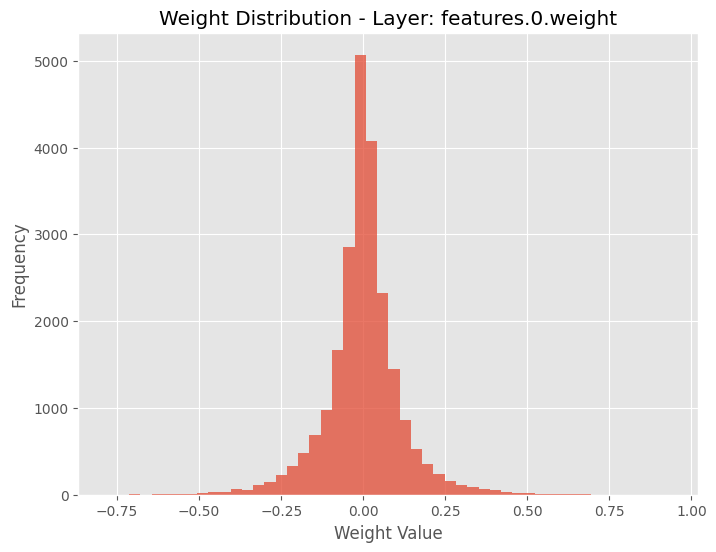

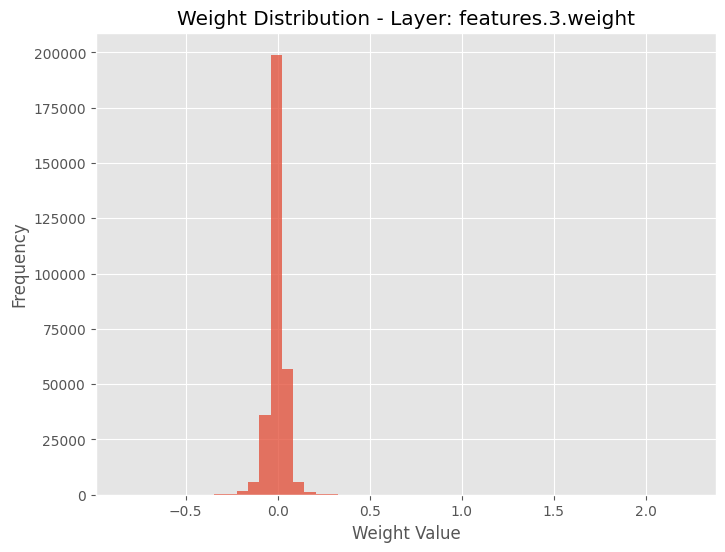

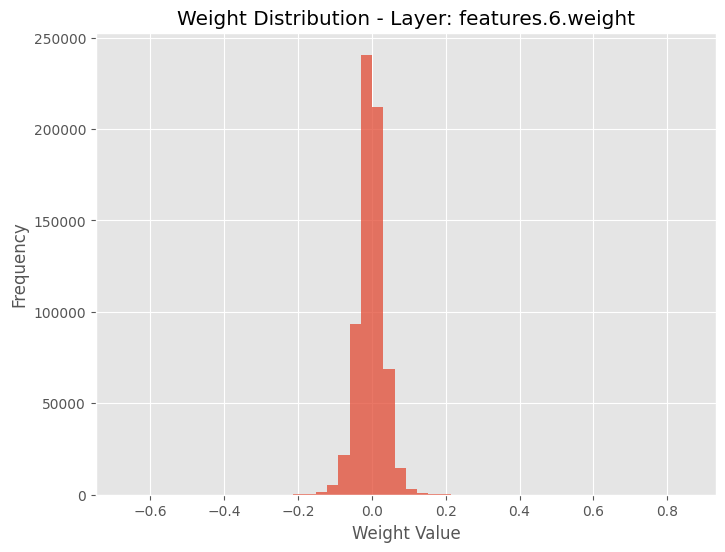

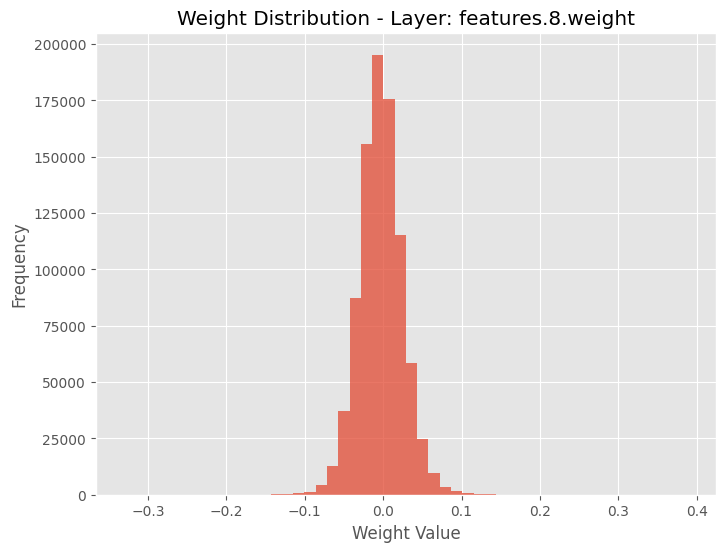

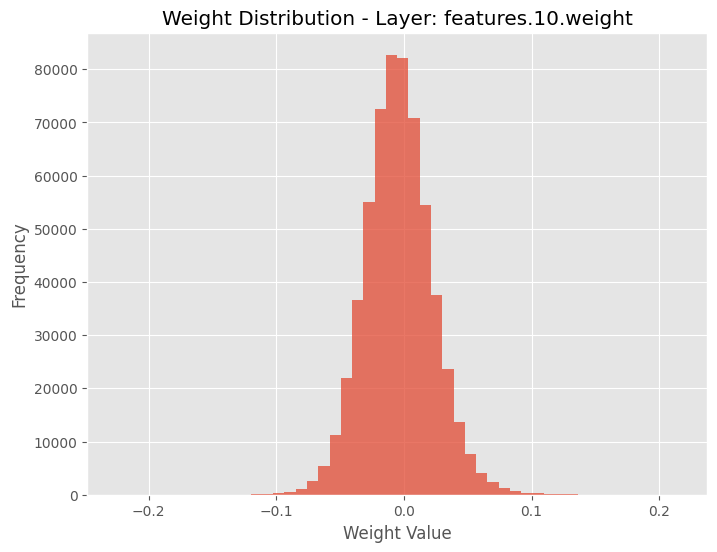

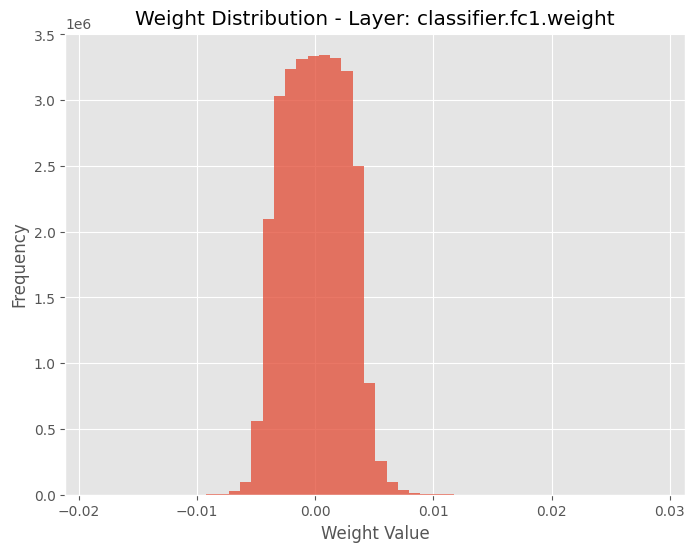

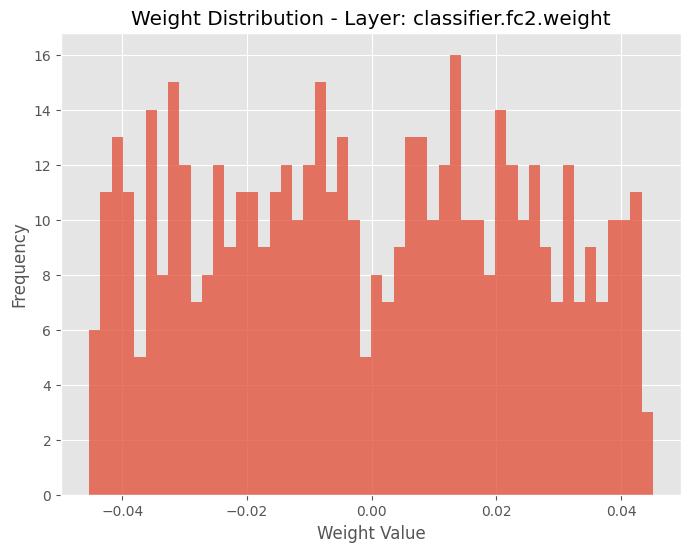

In [ ]:
import torch
import matplotlib.pyplot as plt

for name, param in model.named_parameters():
    if 'weight' in name:
        weights = param.data.cpu().numpy()


        plt.figure(figsize=(8, 6))
        plt.hist(weights.flatten(), bins=50, alpha=0.75)
        plt.title(f'Weight Distribution - Layer: {name}')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()


Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.025662, validation acc: 99.333333,
for class[0]:
 validation precision: 0.992063, validation recall: 1.000000 , validation F1: 0.996016
for class[1]:
 validation precision: 1.000000, validation recall: 0.960000 , validation F1: 0.979592


FileNotFoundError: [Errno 2] No such file or directory: '/content/outputs/accuracy_.png'

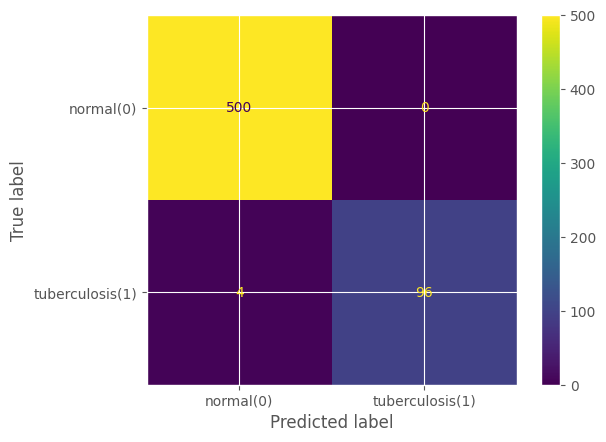

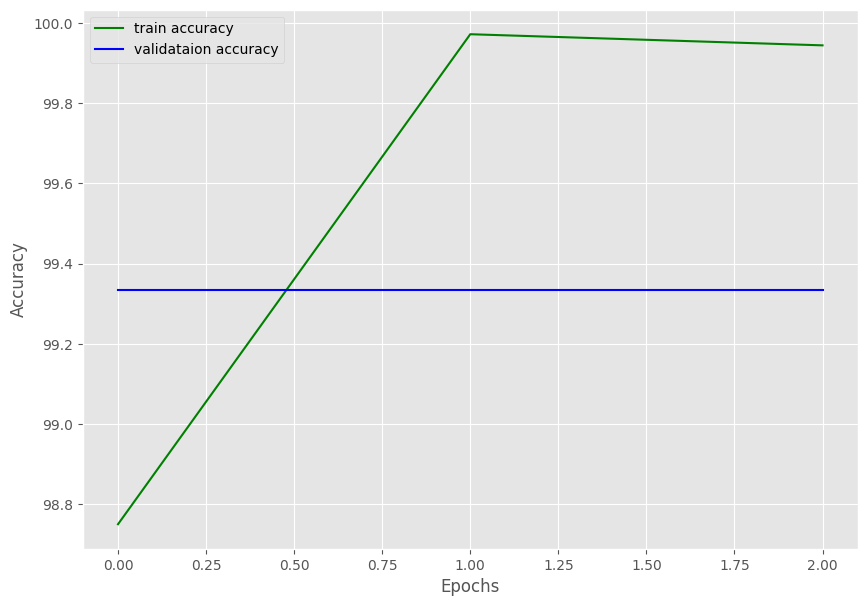

In [ ]:
valid_epoch_loss, valid_epoch_acc,preds,labels = validate(model, test_loader,
                                                 criterion)
prec, rec, f1,_ =precision_recall_fscore_support(y_true=labels,y_pred=preds)
print(f"Validation loss: {valid_epoch_loss:.6f}, validation acc: {valid_epoch_acc:.6f},")
for l in [0,1]:
  print(f"for class[{l}]:\n validation precision: {prec[l]:.6f}, validation recall: {rec[l]:.6f} , validation F1: {f1[l]:.6f}")

cm = confusion_matrix(labels, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['normal(0)','tuberculosis(1)'])
disp.plot()
save_plots(train_acc=train_acc,valid_acc=valid_acc,train_loss=train_loss,valid_loss=valid_loss)

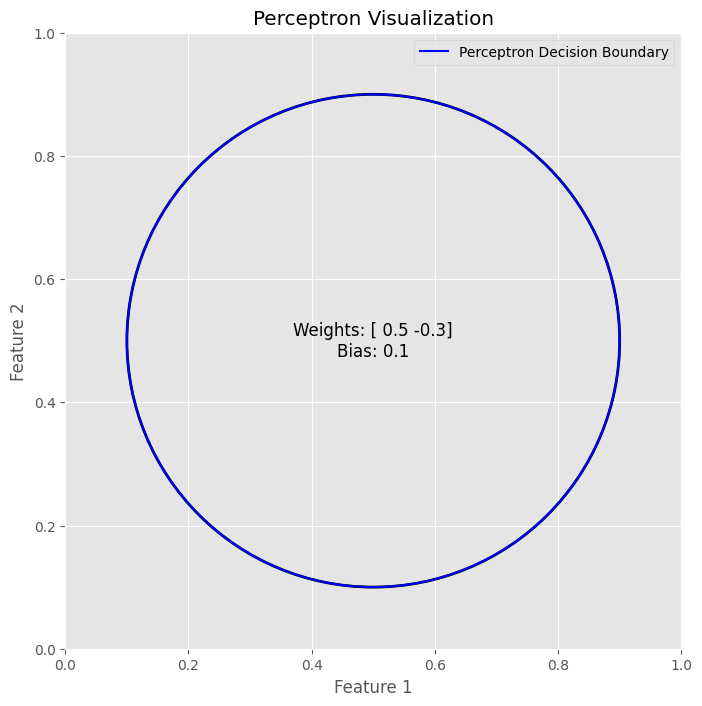

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

w = np.array([0.5, -0.3])
b = 0.1

fig, ax = plt.subplots(figsize=(8, 8))

circle = Circle((0.5, 0.5), 0.4, fill=False, edgecolor='black', linewidth=2)
ax.add_patch(circle)

theta = np.linspace(0, 2*np.pi, 100)
x1 = 0.5 + 0.4 * np.cos(theta)
x2 = 0.5 + 0.4 * np.sin(theta)
plt.plot(x1, x2, color='blue', label='Perceptron Decision Boundary')

ax.text(0.5, 0.5, f'Weights: {w}\nBias: {b}', va='center', ha='center', fontsize=12, color='black')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Perceptron Visualization')

plt.legend()
plt.show()


1/1 [==============================] - 2s 2s/step


<ipython-input-40-e6fdebca577f>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

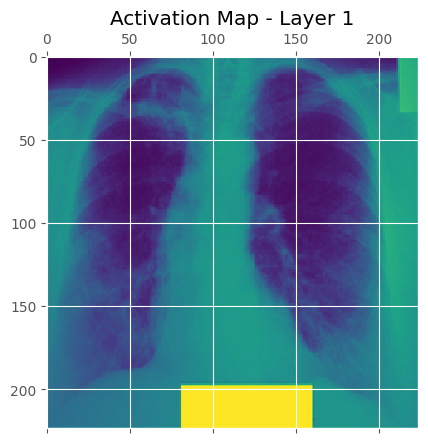

<Figure size 640x480 with 0 Axes>

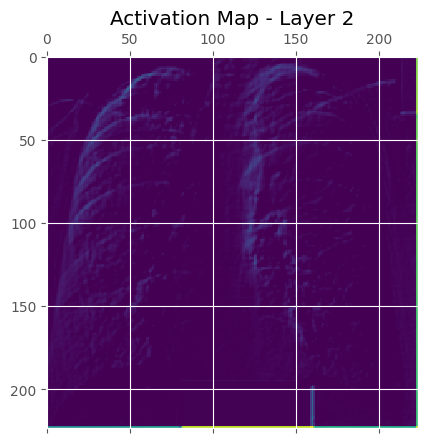

<Figure size 640x480 with 0 Axes>

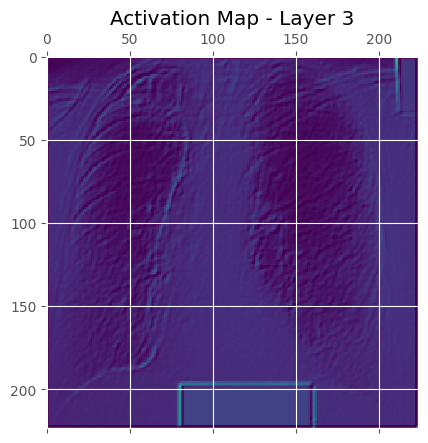

<Figure size 640x480 with 0 Axes>

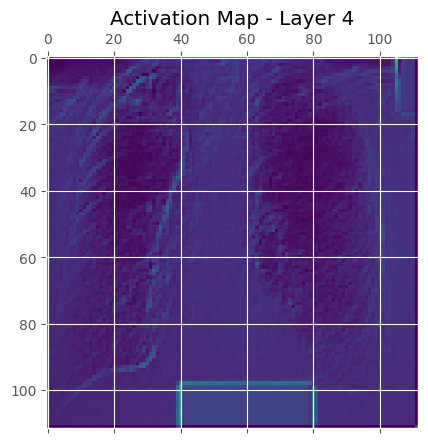

<Figure size 640x480 with 0 Axes>

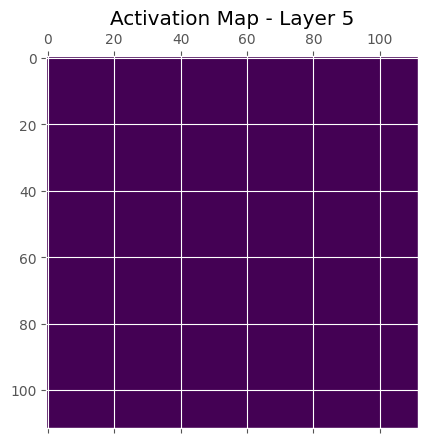

<Figure size 640x480 with 0 Axes>

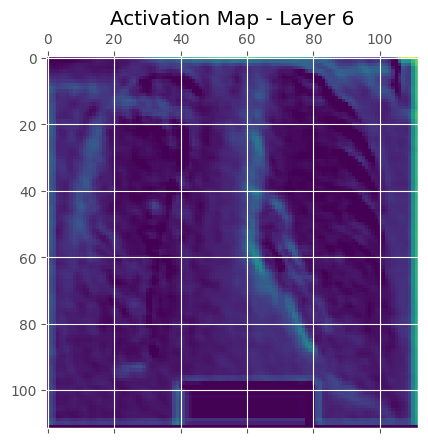

<Figure size 640x480 with 0 Axes>

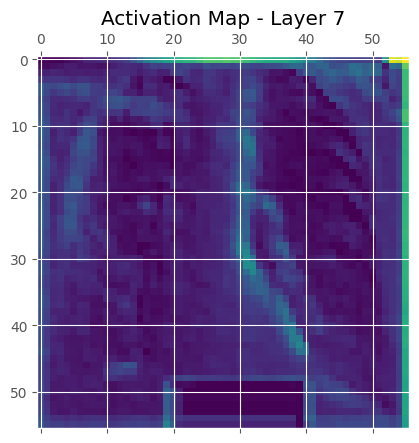

<Figure size 640x480 with 0 Axes>

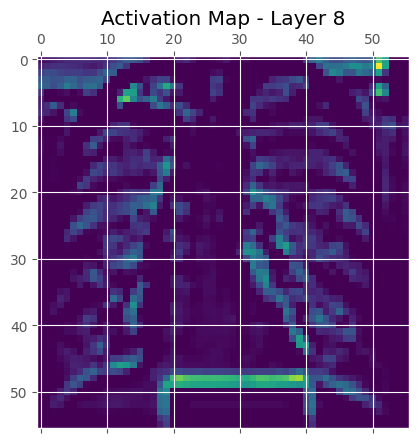

<Figure size 640x480 with 0 Axes>

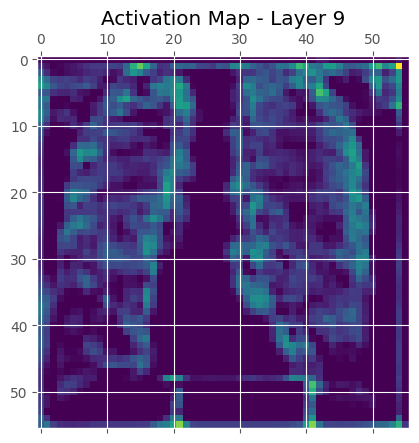

<Figure size 640x480 with 0 Axes>

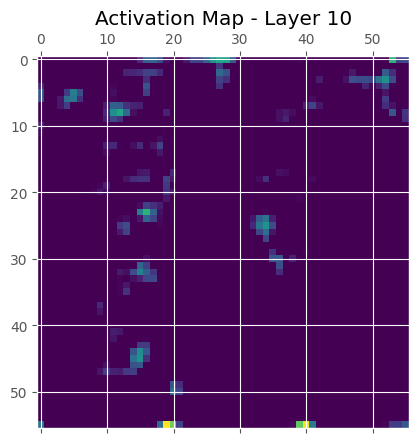

<Figure size 640x480 with 0 Axes>

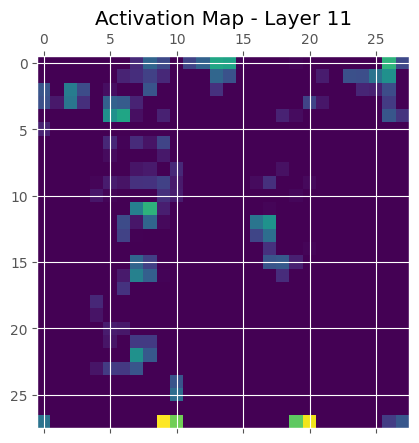

<Figure size 640x480 with 0 Axes>

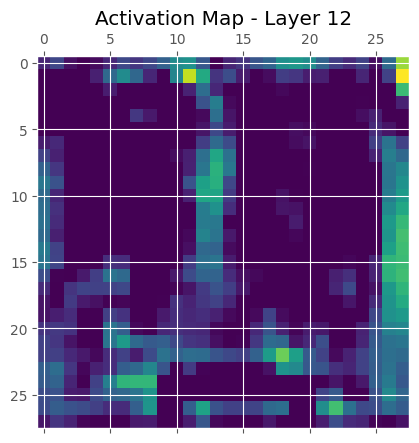

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

img = tf.keras.preprocessing.image.load_img('/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-1.png', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

model = tf.keras.applications.model(weights='imagenet', include_top=True)

layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

for i, activation_map in enumerate(activations):
    plt.figure()
    plt.matshow(activation_map[0, :, :, 0], cmap='viridis')
    plt.title(f'Activation Map - Layer {i+1}')


In [ ]:
pip install torchviz


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(15, 15))
  (classifier): Sequential(
    (dropout1): Dropout(p=0.05, inplace=False)
    (fc1): Linear(in_features=57600, out_features=510, 

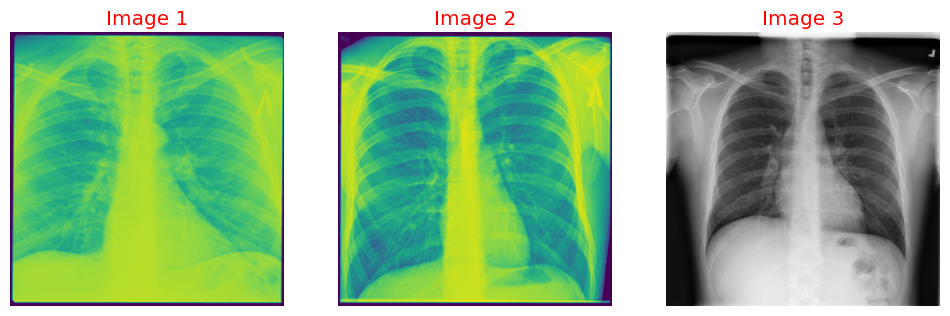

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

def imshow(imgs, titles=None, figsize=(12, 6)):
    num_images = len(imgs)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    for i in range(num_images):
        ax = axes[i]
        img = imgs[i]

        ax.imshow(img)
        ax.axis('off')

        if titles is not None:
            ax.set_title(titles[i], color='red')

    plt.show()

image_paths = [
    "/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png",
    "/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-103.png",
    "/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-10.png"]
sample_images = [Image.open(path) for path in image_paths]
sample_labels = ["Image 1", "Image 2", "Image 3"]
imshow(sample_images, titles=sample_labels)


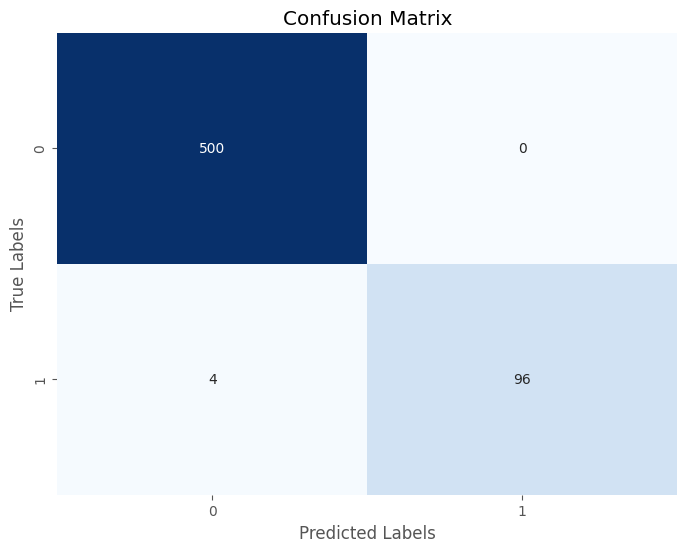

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


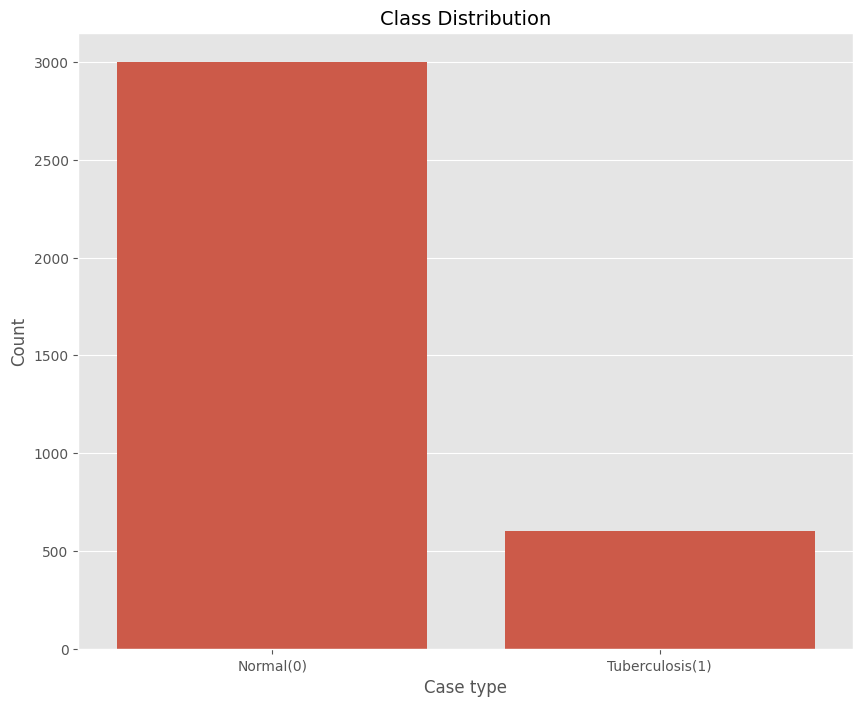

In [ ]:
show_plot(['Normal', 'Tuberculosis'], train_count[1], title='Class Distribution', xticks=['Normal(0)', 'Tuberculosis(1)'])


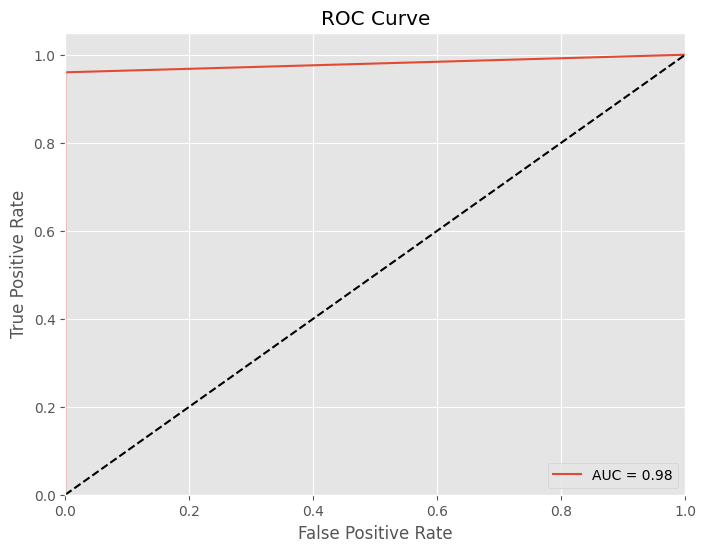

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels_list, preds_list)
auc = roc_auc_score(labels_list, preds_list)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


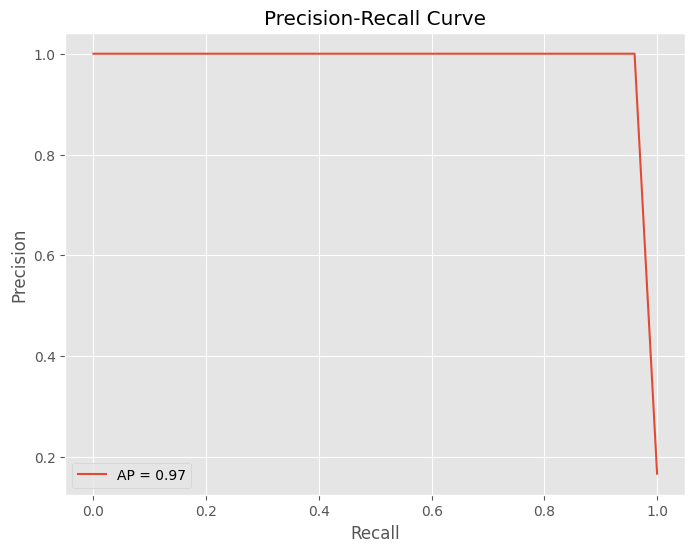

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(labels_list, preds_list)
ap_score = average_precision_score(labels_list, preds_list)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


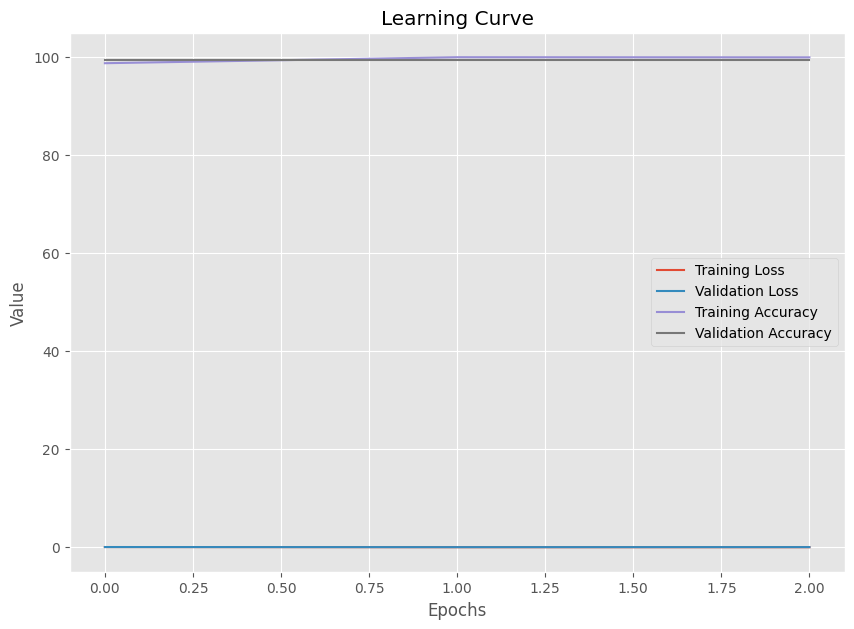

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.title('Learning Curve')
plt.show()


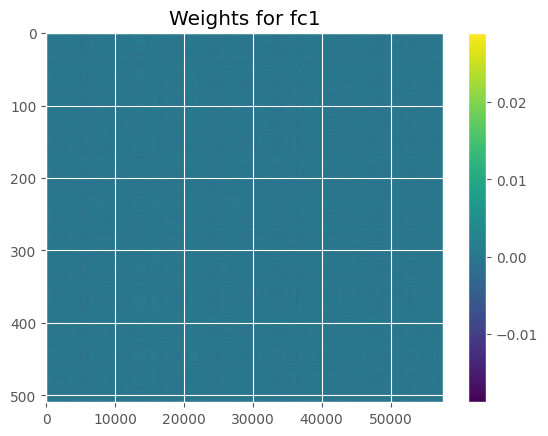

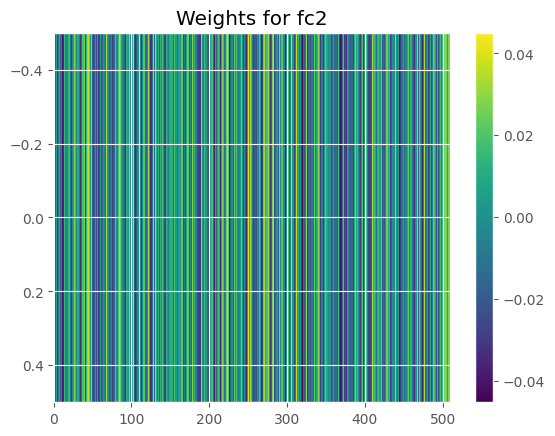

In [ ]:
for name, layer in model.classifier.named_children():
    if isinstance(layer, torch.nn.Linear):
        plt.figure()
        plt.imshow(layer.weight.cpu().detach().numpy(), cmap='viridis', aspect='auto')
        plt.title(f'Weights for {name}')
        plt.colorbar()
        plt.show()


In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

matplotlib.style.use('ggplot')

def calculate_accuracy(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).int()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    return accuracy

accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy on the validation dataset: {accuracy:.2f}%")


Accuracy on the validation dataset: 99.33%


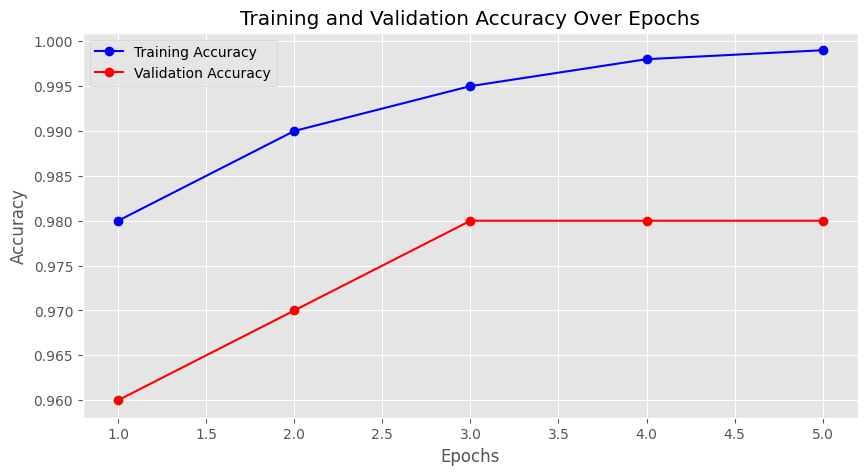

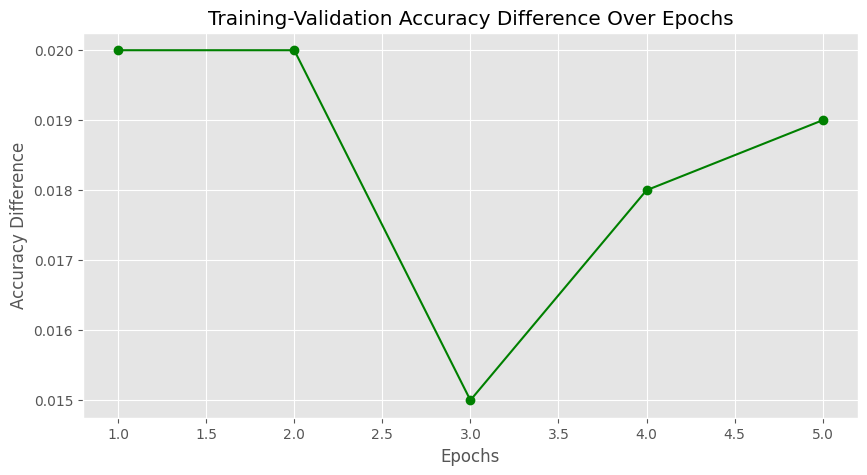

No significant overfitting detected.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_accuracy = [0.98, 0.99, 0.995, 0.998, 0.999]
validation_accuracy = [0.96, 0.97, 0.98, 0.98, 0.98]

epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

accuracy_difference = np.array(train_accuracy) - np.array(validation_accuracy)

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_difference, 'go-')
plt.title('Training-Validation Accuracy Difference Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference')
plt.grid(True)
plt.show()

overfitting_threshold = 0.03
if any(diff > overfitting_threshold for diff in accuracy_difference):
    print("Overfitting detected!")
else:
    print("No significant overfitting detected.")
